# Danilo Montalvo

In [74]:
import pandas as pd
import numpy as np
import os
import glob as glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.utils import plot_model
import tensorflow as tf


# Loading the Data

### Suggested Cross-Product Features

1. **Purpose and Fico Score**: 
   - Combining loan purpose with Fico scores can reveal how creditworthiness influences loan default risks differently based on the loan’s purpose. This can help understand specific risk patterns, such as higher default rates for educational loans regardless of good credit scores.

2. **Purpose and Interest Rate**: 
   - This interaction could show how different loan purposes react to interest rates. For instance, debt consolidation loans might be more sensitive to rate changes, affecting their default likelihood.

3. **Fico and Interest Rate**: 
   - The interaction between a borrower's Fico score and the interest rates they receive might predict loan repayment behaviors. Higher rates may impact borrowers with lower Fico scores more significantly, influencing default rates.

### Justification for Crossing Features

- **Non-linear Impact**: The interactions might affect the loan repayment outcome non-linearly, providing deep insights when simple analysis of individual features might not.
- **Risk Assessment Enhancement**: These cross-products can refine the model’s understanding of risk based on complex relationships between borrower characteristics and loan terms.

### Features Not to Cross

- **Temporal and Unrelated Features**: Avoid crossing temporal features like 'days with credit line' with categorical ones like 'purpose' as their interaction typically does not enhance predictive accuracy and may overcomplicate the model.


In [75]:
df = pd.read_csv('/Users/danilomontalvo/Desktop/MLAssignemnts/Lab5/loan_data.csv') # read in the csv file

data = pd.read_csv('/Users/danilomontalvo/Desktop/MLAssignemnts/Lab5/loan_data.csv')
data.sample(5)

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
2728,1,home_improvement,0.0932,159.74,10.126631,3.89,777,3419.958333,3901,10.6,2,0,0,0
8029,0,major_purchase,0.1186,33.15,10.645425,3.42,657,3180.000000,0,0.0,2,0,0,1
6404,1,debt_consolidation,0.1357,475.56,11.652687,15.43,702,4140.041667,27016,81.9,0,0,0,1
7597,1,credit_card,0.1025,404.81,10.505068,18.38,732,3394.000000,12849,45.6,0,0,0,0
2269,1,credit_card,0.1505,312.23,10.896739,23.80,682,3360.000000,35379,89.4,0,0,0,1


In [76]:
# from this I'm make a decision of which columns to derop
missing_values_count = data.isna().sum()
print(missing_values_count)

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64


# Loading and preprocess Data

In [77]:
df = pd.read_csv('/Users/danilomontalvo/Desktop/MLAssignemnts/Lab5/loan_data.csv') 
# Preliminary preprocessing
df['not.fully.paid'] = df['not.fully.paid'].astype(int)  # Ensuring binary target variable is integer

# Define categorical and numeric features
categorical_features = ['purpose']  # Add other categorical features as needed
numeric_features = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util']

# Create a transformer for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a transformer for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Prepare feature matrix and target vector
X = df.drop('not.fully.paid', axis=1)
y = df['not.fully.paid']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply transformations
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## Define and Compile the Wide and Deep Model

In [78]:

# Define input layers
input_numeric = Input(shape=(len(numeric_features),))
input_categorical = Input(shape=(X_train.shape[1] - len(numeric_features),))

# Define the deep path
deep_path = concatenate([input_numeric, input_categorical])
deep_path = Dense(128, activation='relu')(deep_path)
deep_path = Dense(128, activation='relu')(deep_path)

# Define the wide path
wide_path = input_categorical  # Directly use categorical input for the wide path

# Combine wide and deep paths
combined = concatenate([wide_path, deep_path])
output = Dense(1, activation='sigmoid')(combined)

# Create the model
model = Model(inputs=[input_numeric, input_categorical], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model architecture
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 concatenate_2 (Concatenate)    (None, 15)           0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 128)          2048        ['concatenate_2[0][0]']    

### Evaluation Metrics

#### Primary Metric: Area Under the ROC Curve (AUC-ROC)
- **Why AUC-ROC?**: The task involves predicting whether a loan will be fully paid or not, which is inherently a binary classification problem. AUC-ROC is effective here because it evaluates the model’s ability to discriminate between the classes across all possible classification thresholds, providing a robust measure of performance irrespective of class distribution.
- **Relevance**: This metric is particularly useful in credit risk modeling where the costs of false negatives (failing to predict a default) and false positives (falsely predicting default) are very different. It allows us to assess the trade-off between sensitivity (true positive rate) and specificity (false positive rate).

#### Secondary Metric: F1-Score
- **Why F1-Score?**: Given that financial datasets can often be imbalanced (fewer defaults than non-defaults), F1-score is an appropriate metric as it balances the precision and recall of the classifier, ensuring that we do not over-prioritize one at the expense of the other.

### Data Splitting Method

#### Shuffle Split
- **Chosen Method**: Shuffle split cross-validation will be used.
- **Justification**: This method involves random sampling of the data to create multiple training and testing sets. It is suitable for our data since it ensures that each sample gets the possibility of being tested across multiple splits, providing a thorough mixing of the data and reducing variance in the evaluation of the model.
- **Realistic Mirroring**: In practice, lending models encounter data that arrives in no specific order, and their performance must be stable across various scenarios and data distributions. Shuffle split helps simulate this by evaluating the model on multiple random samples of the data.

### Why Not Stratified or Other Methods?
- **Stratified Cross-Validation**: While stratified 10-fold cross-validation ensures that each fold is a good representative of the whole, it is less critical in large datasets where random sampling is likely to produce similar distributions across folds. Given the large size of the dataset and its diversity, shuffle split is deemed sufficient for a realistic and robust assessment.


# Training the Model

Epoch 1/50
240/240 [==============================] - 1s 2ms/step - loss: 0.4399 - accuracy: 0.8340 - val_loss: 0.4115 - val_accuracy: 0.8408
Epoch 2/50
240/240 [==============================] - 0s 2ms/step - loss: 0.4204 - accuracy: 0.8396 - val_loss: 0.4174 - val_accuracy: 0.8408
Epoch 3/50
240/240 [==============================] - 1s 3ms/step - loss: 0.4167 - accuracy: 0.8401 - val_loss: 0.4143 - val_accuracy: 0.8413
Epoch 4/50
240/240 [==============================] - 0s 2ms/step - loss: 0.4133 - accuracy: 0.8395 - val_loss: 0.4146 - val_accuracy: 0.8403
Epoch 5/50
240/240 [==============================] - 0s 2ms/step - loss: 0.4101 - accuracy: 0.8404 - val_loss: 0.4147 - val_accuracy: 0.8413
Epoch 6/50
240/240 [==============================] - 0s 2ms/step - loss: 0.4092 - accuracy: 0.8400 - val_loss: 0.4142 - val_accuracy: 0.8382
Epoch 7/50
240/240 [==============================] - 0s 2ms/step - loss: 0.4066 - accuracy: 0.8399 - val_loss: 0.4185 - val_accuracy: 0.8382
Epoch 

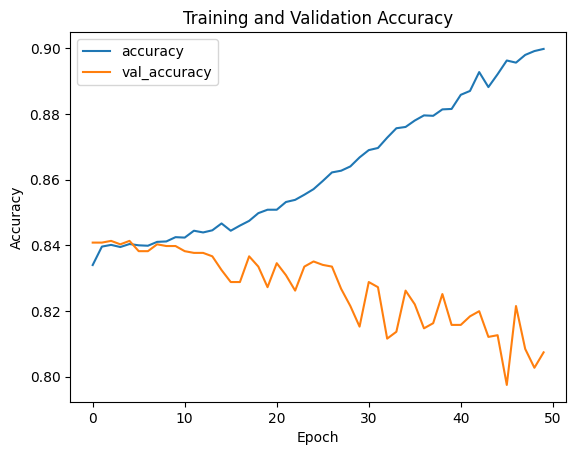

In [79]:
# Fit the model
history = model.fit([X_train[:, :len(numeric_features)], X_train[:, len(numeric_features):]], y_train, 
                    epochs=50, batch_size=32, validation_data=([X_test[:, :len(numeric_features)], X_test[:, len(numeric_features):]], y_test))

# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()



# Evaluating the Model

In [81]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([X_test[:, :len(numeric_features)], X_test[:, len(numeric_features):]], y_test)
print(f"The Test Accuracy for this model is: {test_accuracy:.4f}")

60/60 [==============================] - 0s 2ms/step - loss: 0.5706 - accuracy: 0.8074
The Test Accuracy for this model is: 0.8074
